1. Import Necessary liibraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import cv2
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import PIL
import os

2. Load the dataset

In [204]:
# import each path of the image classes
glaucoma = Path('/content/drive/MyDrive/dataset/glaucoma')
cataract = Path('/content/drive/MyDrive/dataset/cataract')
normal = Path('/content/drive/MyDrive/dataset/normal')
diabetic_retinopathy = Path('/content/drive/MyDrive/dataset/diabetic_retinopathy')

In [164]:
# create a dataframe with the file path and the labels
disease_type = [glaucoma, cataract,normal,diabetic_retinopathy]
df = pd.DataFrame()
from tqdm import tqdm
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

/content/drive/MyDrive/dataset/normal: 100%|██████████| 1074/1074 [00:00<00:00, 1818.74it/s]
/content/drive/MyDrive/dataset/diabetic_retinopathy: 100%|██████████| 1108/1108 [00:00<00:00, 1728.60it/s]


In [165]:
# display the dataframe
df

,image,disease_type
0,/content/drive/MyDrive/dataset/glaucoma/_26_84...,0
1,/content/drive/MyDrive/dataset/glaucoma/_104_9...,0
2,/content/drive/MyDrive/dataset/glaucoma/1255_r...,0
3,/content/drive/MyDrive/dataset/glaucoma/_52_36...,0
4,/content/drive/MyDrive/dataset/glaucoma/1256_r...,0
...,...,...
4282,/content/drive/MyDrive/dataset/diabetic_retino...,3
4283,/content/drive/MyDrive/dataset/diabetic_retino...,3
4284,/content/drive/MyDrive/dataset/diabetic_retino...,3
4285,/content/drive/MyDrive/dataset/diabetic_retino...,3


In [166]:
# check the count of the target label
df.disease_type.value_counts()

,count
disease_type,
3,1108
1,1088
2,1074
0,1017


Visualizing Images in the dataset

In [167]:
# define function to plot sample images
def plot_image(n, num_samples=3):
    disease_labels = ['glaucoma', 'cataract', 'normal', 'diabetic_retinopathy']
    images = df[df['disease_type'] == n].sample(num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.show()

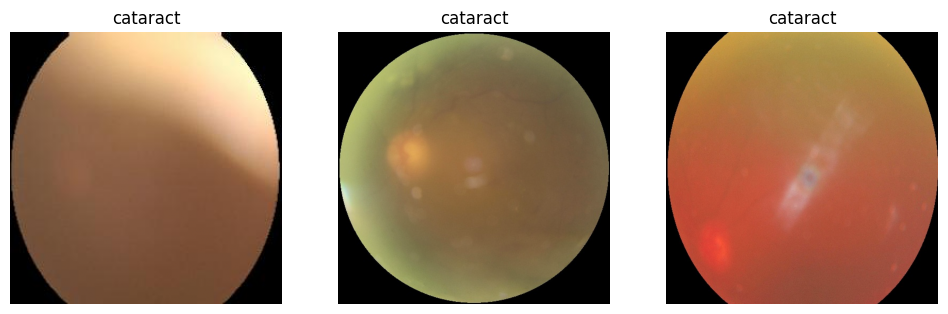

In [168]:
plot_image(1)

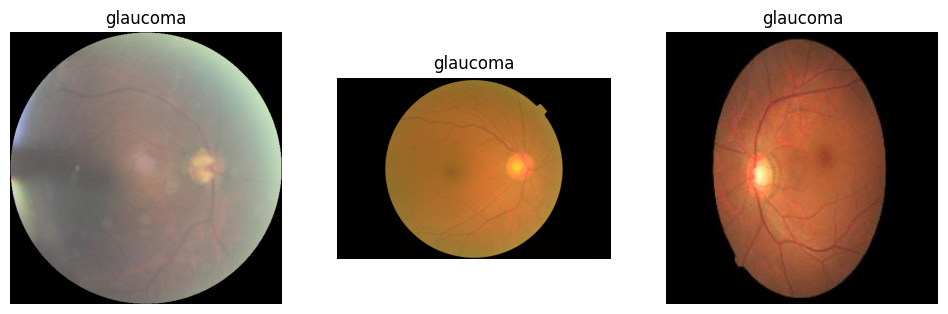

In [169]:
plot_image(0)

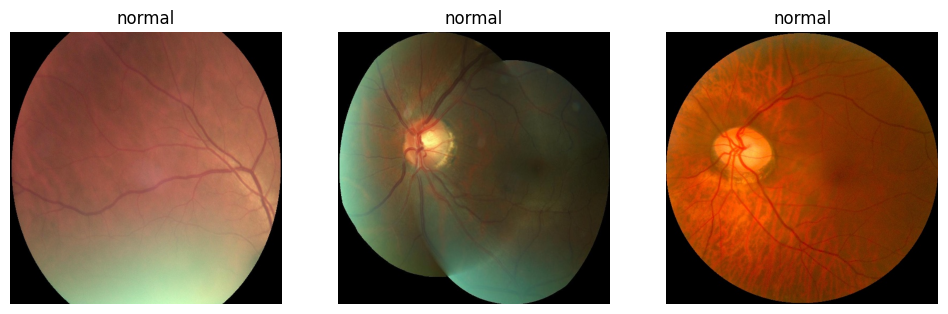

In [170]:
plot_image(2)

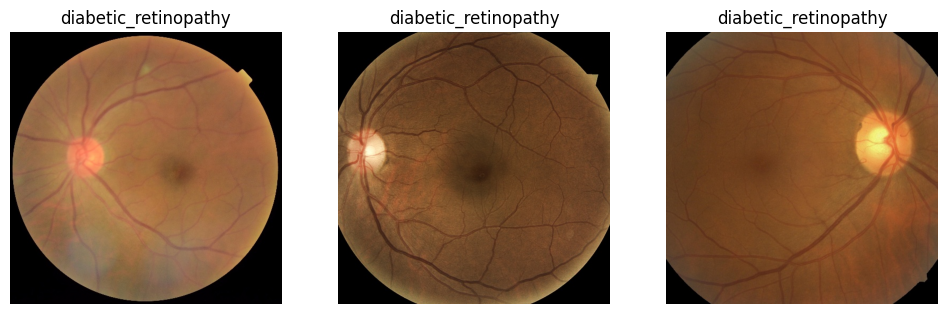

In [171]:
plot_image(3)

In [172]:
# map the labels to the disease type
df['disease_type'] = df['disease_type'].map({0:'glaucoma',1:'cataract',2:'normal',3:'diabetic_retinopathy'})


In [173]:
# check the lebel count to verify it has been mapped
df.disease_type.value_counts()

,count
disease_type,
diabetic_retinopathy,1108
cataract,1088
normal,1074
glaucoma,1017


In [174]:
# randomising the dataset
df1 = df.sample(frac=1).reset_index(drop=True)

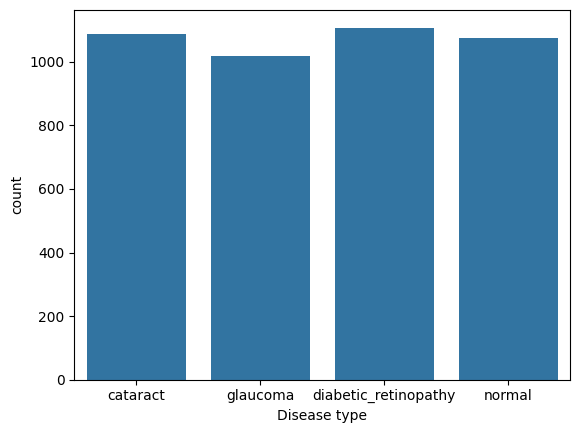

In [175]:
# create a countplot of the disease type
sns.countplot(x = 'disease_type', data = df1)
plt.xlabel("Disease type")
plt.show()

In [176]:
#import necessary libraries for the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

Model Training

In [177]:
# augumentation of images
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [178]:
# create the train data
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          subset = 'training')

Found 3430 validated image filenames belonging to 4 classes.


In [179]:
# create the validation data
valid_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = False,
                                          subset = 'validation')

Found 857 validated image filenames belonging to 4 classes.


In [180]:
labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(224,224, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [181]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,446,756 (24.59 MB)

 Trainable params: 6,446,756 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [183]:
# fitting the model
his = model.fit(
  train_data,
    validation_data=valid_data,
  epochs=5
)

Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.8717 - loss: 0.3208 - val_accuracy: 0.8448 - val_loss: 0.4026
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.8786 - loss: 0.3026 - val_accuracy: 0.8518 - val_loss: 0.3678
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.8881 - loss: 0.2843 - val_accuracy: 0.8670 - val_loss: 0.3522
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.9011 - loss: 0.2412 - val_accuracy: 0.8635 - val_loss: 0.3457
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.9142 - loss: 0.2165 - val_accuracy: 0.8180 - val_loss: 0.5647


Visualizing Model Performance

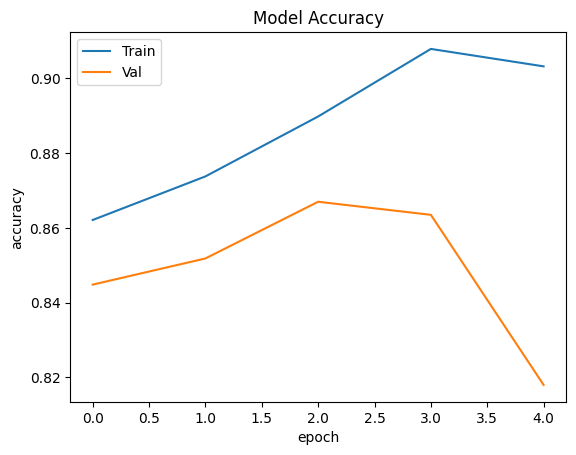

In [185]:
# create a plot of accuracy and val_acuracy for each epoch
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

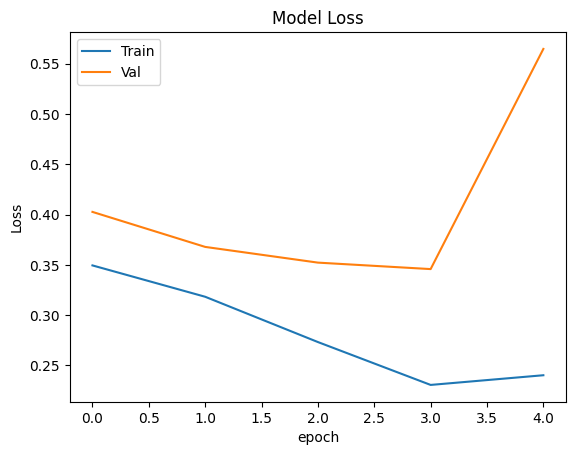

In [186]:
# create a plot of loss and val_loss for each epoch
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [193]:
confmat = ConfusionMatrix(task="multiclass", num_classes=NUMBER_OF_CLASSES)
cm = confmat(preds, targets)

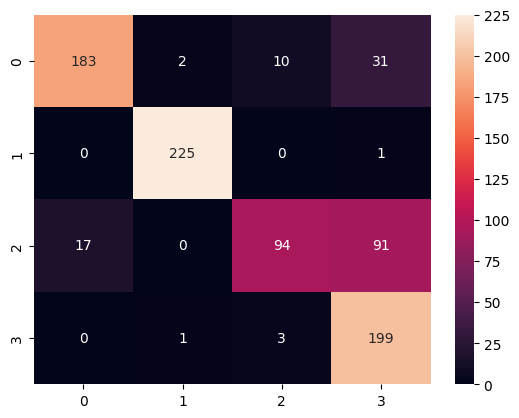

In [196]:
# import seaborn as sns # visualization (already imported)
import matplotlib.pyplot as plt

# ... (other code) ...

# create confusion matrix plot
# sn.heatmap(cm, annot=True, fmt=".0f") # Incorrect - 'sn' is not defined
sns.heatmap(cm, annot=True, fmt=".0f") # Correct - Use 'sns' which is the alias for seaborn
plt.show()

Model Evaluation

In [188]:
# evaluate the model
y_test = valid_data.classes
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred,axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 919ms/step


In [189]:

# Get predictions and true labels for accuracy calculation
preds = torch.tensor(y_pred)  # Assuming y_pred is a NumPy array
targets = torch.tensor(y_test) # Assuming y_test is a NumPy array

# Assuming you are using a GPU, otherwise change to 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the number of classes (4 in this case)
NUMBER_OF_CLASSES = 4

# Calculate accuracy using torchmetrics
accuracy = Accuracy(task="multiclass", num_classes=NUMBER_OF_CLASSES).to(device)
accuracy = accuracy(preds, targets)
print(f"Accuracy: {100 * accuracy:.2f}%")

Accuracy: 81.80%


In [190]:
precision = Precision(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
precision = precision(preds, targets)
print(f"Precision: {100 * precision:.2f}%")

Precision: 81.80%


In [191]:
recall = Recall(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
recall = recall(preds, targets)
print(f"Recall: {100 * recall:.2f}%")


Recall: 81.80%


In [ ]:
# generate classification report of the model
print(classification_report(y_test,y_pred,target_names = labels))

In [200]:
f1 = F1Score(task="multiclass", num_classes=NUMBER_OF_CLASSES)
f1 = f1(preds, targets)
print(f"F1 Score: {100 * f1:.2f}%")

F1 Score: 81.80%
